# Error mitigation on Amazon Braket 

In this example notebook, you will learn how to get started with using IonQ's Aria QPU on Amazon Braket. You’ll learn how Aria's two built-in error mitigation techniques work, how to switch between them, and the performance difference you can expect to see with and without these techniques for toy problems. 

## Quantum phase estimation 

Quantum phase estimation (QPE) is a fundamental algorithm in quantum computing that plays a crucial role in many  applications. The QPE algorithm is designed to estimate the eigenvalues of a unitary operator. Below, we provide an example implementation in the Braket SDK. 

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from braket.aws import AwsDevice
from braket.circuits import Circuit
from braket.devices import LocalSimulator
from braket.tracking import Tracker
from phase_estimation import phase_estimation_circuit

%matplotlib inline

In [ ]:
cost_tracker = Tracker().start()

In [5]:
# device = LocalSimulator()
device = AwsDevice("arn:aws:braket:us-east-1::device/qpu/ionq/Aria-1")

In [6]:
circ = phase_estimation_circuit(n_qubits=4, phase=np.pi / 4)
print(circ)

T  : |0|   1    |2|    3    |4|   5    |6|    7    |8|   9    |10|   11    |12|   13   |14|   15    |16|   17   |18|   19    |20|   21   |22|   23    |24 |   25    |26|   27    |28 |   29   |30 |   31    |32 |   33    |34|   35    |36|   37   |38|   39    |40|
                                                                                                                                                                                                                                                                    
q0 : -H-Rz(6.28)------------------------------------------------------------------------C------------C--SWAP------------------------------------------------------------------------X-Rz(0.20)---X-Rz(-0.20)---X-Rz(0.39)--X--Rz(-0.39)-X--Rz(0.79)-X--Rz(-0.79)-H--
                                                                                        |            |  |                                                                           |            |             |         

## Aria 

First, we run the QPE circuit on the Aria device with the maximum number of shots per task (2,500). 

In [5]:
task = device.run(circ, shots=2500)
print(task)

AwsQuantumTask('id/taskArn':'arn:aws:braket:us-east-1:<account_id>:quantum-task/6bd86be9-2811-49b2-a62e-86cd328d444f')


In [13]:
probs = task.result().measurement_probabilities

{'00000': 0.0028,
 '10000': 0.0038,
 '01000': 0.0102,
 '11000': 0.0002,
 '00100': 0.0002,
 '01100': 0.0002,
 '10010': 0.0002,
 '01010': 0.0002,
 '11010': 0.0004,
 '00110': 0.0002,
 '00001': 0.015,
 '10001': 0.0084,
 '01001': 0.8792,
 '11001': 0.03,
 '00101': 0.0046,
 '10101': 0.0006,
 '01101': 0.0128,
 '11101': 0.0026,
 '00011': 0.0004,
 '10011': 0.002,
 '01011': 0.0074,
 '11011': 0.011,
 '00111': 0.0018,
 '10111': 0.004,
 '01111': 0.001,
 '11111': 0.0008}

## Error Mitigation with debiasing

Debiasing aims to reduce the accumulation of coherent errors by using different physical implementations of the same circuit and using classical compute to combine the results and extract the clearest possible signal from a noisy source [1]. 

IonQ's debiasing method uses different implementations of a circuit through various qubit permutations and/or gate decompositions. The implementations can be chosen to reduce the effects of certain types of noise. Aggregating the results from all implementations reduces the effect of systematic errors and can improve the accuracy of your results. 

To use debiasing, a minimum of 2500 shots is required. In the Braket SDK, you can enable debiasing with a single line of code.

In [7]:
from braket.error_mitigation import Debias

task_em = device.run(circ, shots=2500, device_parameters={"errorMitigation": Debias()})
print(task_em)

AwsQuantumTask('id/taskArn':'arn:aws:braket:us-east-1:<account_id>:quantum-task/522e8472-78ff-4997-850e-5d9d9a8f5474')


The results from debiasing are returned like normal measurement probabilities. Any expecation value or result type will be computed from these probabilities. 

In [14]:
result = task_em.result()
debias_probs = result.measurement_probabilities

### Sharpening

For quantum algorithms where the expected output distribution consists of few high-probability bitstrings, we can use IonQ’s sharpening strategy to post-process the results of a debiased run. Sharpening is a non-linear aggregation strategy that compares the results of each variant and discards inconsistent shots, favoring the most likely measurement outcome across variants. 
This is in contrast the the default aggregation for debiasing, which averages all the measurements together. Since sharpening is a post-processing technique, it can be applied at no additional cost to a debiased run. It’s important to keep in mind that because there is a minimum probability threshold for a shot to be considered consistent, sharpening can distort the correct probability distribution if applied to a non-sparse output distribution.

The sharpened probabilities are available in the task result via a single line of code:

In [15]:
sharp_probs = result.additional_metadata.ionqMetadata.sharpenedProbabilities

Sharpening your results will return a renormalized probability distribution rather than the full distribution of measurements counts, and is available at no additional cost when you run with the Debias() strategy. Note that expectation values will be computed using the debiased probabilities, **not** the sharpened probabilities. 

## Compare results from error mitigation

In [16]:
debias_off = pd.DataFrame.from_dict(probs, orient="index").rename(columns={0: "debias off"})
debias_on = pd.DataFrame.from_dict(debias_probs, orient="index").rename(columns={0: "debias on"})
sharpen_on = pd.DataFrame.from_dict(sharp_probs, orient="index").rename(
    columns={0: "debias on, sharpened"}
)
df = debias_off.join(debias_on).join(sharpen_on)
df2 = df.sort_values(by="debias off").tail(10)
df2

,debias off,debias on,"debias on, sharpened"
10111,0.0040,0.0028,NaN
00101,0.0046,0.0076,NaN
01011,0.0074,0.0112,NaN
10001,0.0084,0.0068,NaN
01000,0.0102,0.0088,NaN
11011,0.0110,0.0120,NaN
01101,0.0128,0.0108,NaN
00001,0.0150,0.0088,NaN
11001,0.0300,0.0316,NaN
01001,0.8792,0.8852,1.0


<AxesSubplot: xlabel='Bitstring', ylabel='Probability'>

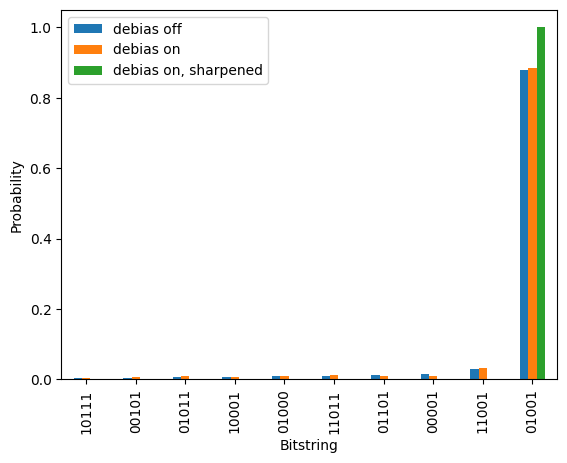

In [18]:
df2.plot.bar(logy=False, ylabel="Probability", xlabel="Bitstring")

In [ ]:
print("Task Summary")
print(
    "Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2)."
)
print(
    f"Estimated cost to run this example: {cost_tracker.qpu_tasks_cost() + cost_tracker.simulator_tasks_cost():.3f} USD"
)

Task Summary
Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).
Estimated cost to run this example: 150.6 USD


## References 

[1] “Enhancing quantum computer performance via symmetrization”,  https://arxiv.org/abs/2301.07233